In [1]:
import os, sys
import pandas as pd

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

# scripts/run_bau.py 内の run_bau 関数を取り込む
from scripts.calibrate import calibrate
from scripts.run_bau import run_bau
from scripts.run_policy import run_policy

# 実行
calibrate()
run_bau()
run_policy()


bau    = pd.read_csv('../outputs/tables/results_bau.csv')
policy = pd.read_csv('../outputs/tables/results_policy.csv')

print("BAU results:")
display(bau.head())
print("Policy results:")
display(policy.head())

Calibration saved → C:\Users\user\OneDrive\Desktop\cge-spatial-dynamic\models\calibrated_params.json
BAU results → C:\Users\user\OneDrive\Desktop\cge-spatial-dynamic\outputs\tables\results_bau.csv
Policy results → C:\Users\user\OneDrive\Desktop\cge-spatial-dynamic\outputs\tables\results_policy.csv
BAU results:


,region,time,GDP,emissions
0,A,0,240.000000,0.000000
1,A,1,244.800000,78.540000
2,A,2,249.696000,80.110800
3,A,3,254.689920,81.713016
4,A,4,259.783722,83.347277


Policy results:


,region,time,GDP,emissions
0,A,0,240.000000,0.000000
1,A,1,240.950000,77.110000
2,A,2,241.913499,77.422112
3,A,3,242.880664,77.731569
4,A,4,243.851700,78.042341


# Visualize Results
Load simulation outputs and generate plots.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load BAU and Policy results
bau = pd.read_csv('../outputs/tables/results_bau.csv')  # columns: region, time, GDP, emissions
policy = pd.read_csv('../outputs/tables/results_policy.csv')  # same structure
results = pd.concat([bau.assign(scenario='BAU'), policy.assign(scenario='Policy')])


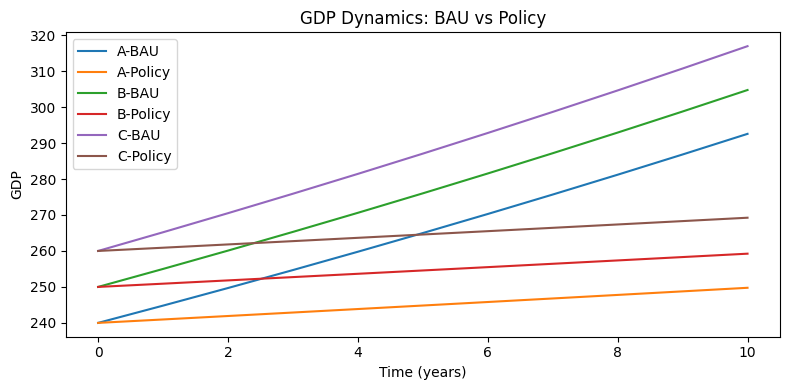

In [9]:
# Time series plot of GDP over time
fig, ax = plt.subplots(figsize=(8,4))
for (region, scenario), grp in results.groupby(['region','scenario']):
    ax.plot(grp['time'], grp['GDP'], label=f"{region}-{scenario}")
ax.set_xlabel('Time (years)')
ax.set_ylabel('GDP')
ax.set_title('GDP Dynamics: BAU vs Policy')
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/figures/gdp_dynamics.png')

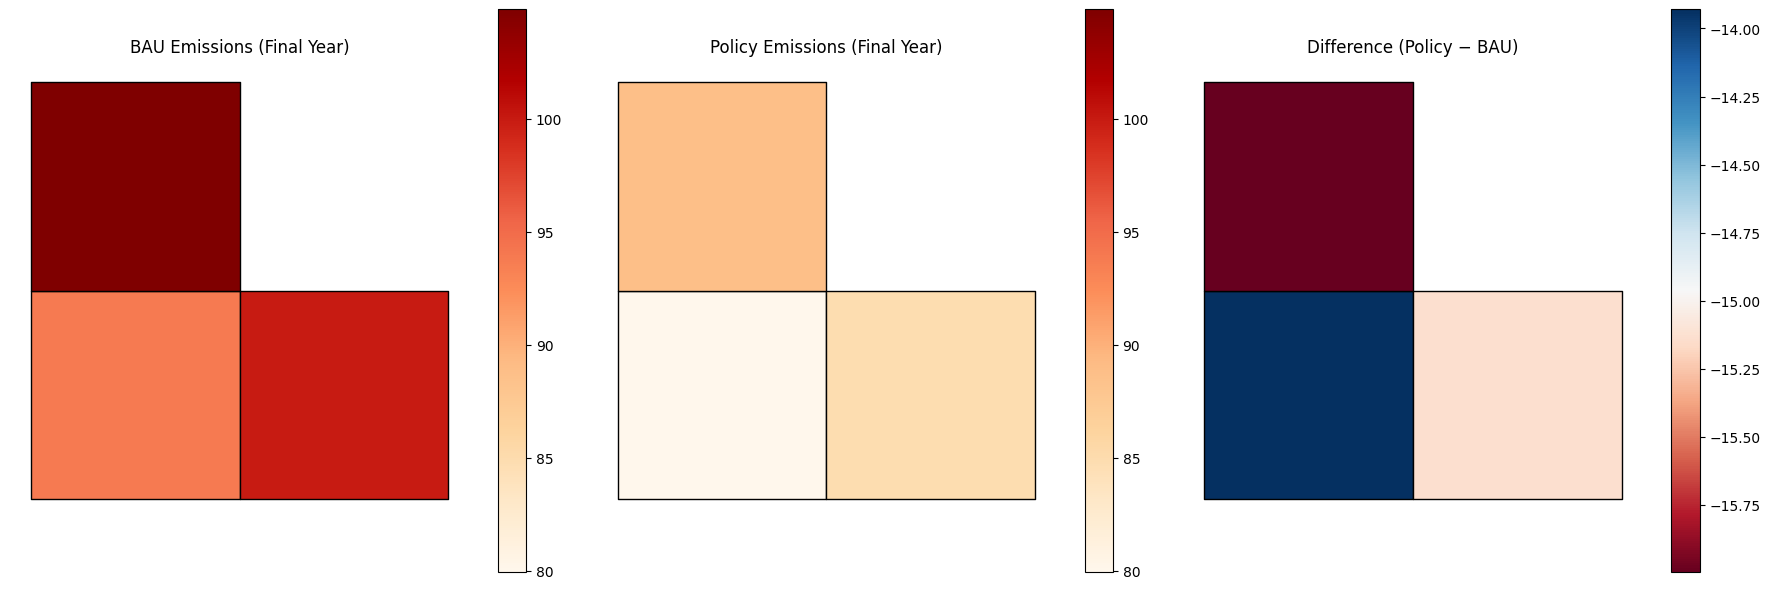

In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1) 結果読み込み（前提：results DataFrame に読み込まれている）
bau    = results[results['scenario']=='BAU']
policy = results[results['scenario']=='Policy']
t_max  = results['time'].max()

# 2) 最終年データを抽出
bau_final     = bau[bau['time']==t_max][['region','emissions']]
policy_final = policy[policy['time']==t_max][['region','emissions']]

# 3) GeoDataFrame 読み込み
geo = gpd.read_file('../data/shapefiles/regions.geojson')

# 4) マージ
map_bau    = geo.merge(bau_final,     on='region')
map_policy = geo.merge(policy_final,  on='region')

# 5) カラースケール共通化のための vmin/vmax 計算
vmin = min(map_bau['emissions'].min(), map_policy['emissions'].min())
vmax = max(map_bau['emissions'].max(), map_policy['emissions'].max())

# 6) ３パネル作成
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# BAU
map_bau.plot(
    column='emissions',
    ax=axes[0],
    cmap='OrRd',
    vmin=vmin, vmax=vmax,
    legend=True,
    edgecolor='black'
)
axes[0].set_title('BAU Emissions (Final Year)')
axes[0].axis('off')

# Policy
map_policy.plot(
    column='emissions',
    ax=axes[1],
    cmap='OrRd',
    vmin=vmin, vmax=vmax,
    legend=True,
    edgecolor='black'
)
axes[1].set_title('Policy Emissions (Final Year)')
axes[1].axis('off')

# 差分マップ
diff_df = policy_final.copy()
diff_df['emissions'] = policy_final['emissions'] - bau_final['emissions']
map_diff = geo.merge(diff_df, on='region')
map_diff.plot(
    column='emissions',
    ax=axes[2],
    cmap='RdBu',
    legend=True,
    edgecolor='black'
)
axes[2].set_title('Difference (Policy − BAU)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/choropleth.png')
plt.show()


In [7]:
import plotly.graph_objects as go
import plotly.io as pio

# Notebook 向けにレンダラーを設定
pio.renderers.default = 'notebook_connected'  
# 他の選択肢：'notebook', 'jupyterlab', 'png', 'colab' など

# 図の定義
labels  = ['Household','Government','Investment','Exports']
sources = [0,0,0,1,2,3]
targets = [1,2,3,2,3,0]
values  = [50,15,5,30,20,5]

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels),
    link=dict(source=sources, target=targets, value=values)
)])
fig.update_layout(title_text='Inter-sectoral Flows (Sample Data)', font_size=10)

# Notebook 内に表示
fig.show()


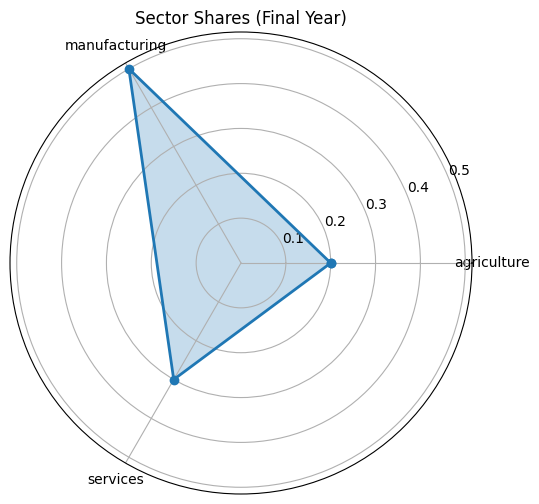

In [11]:
# Radar chart of sector shares in final year
import numpy as np
sectors = ['agriculture','manufacturing','services']
data = [0.2, 0.5, 0.3]  # replace with final-year shares per region
angles = np.linspace(0, 2*np.pi, len(sectors), endpoint=False).tolist()
data += data[:1]  # cyclic repeat
angles += angles[:1]

fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6,6))
ax.plot(angles, data, 'o-', linewidth=2)
ax.fill(angles, data, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), sectors)
ax.set_title('Sector Shares (Final Year)')
ax.grid(True)
plt.savefig('../outputs/figures/sector_shares.png')